In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

#   Camera Calibration

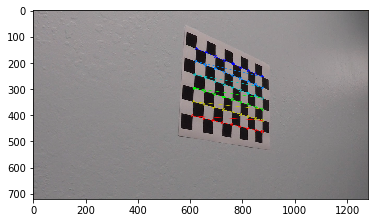

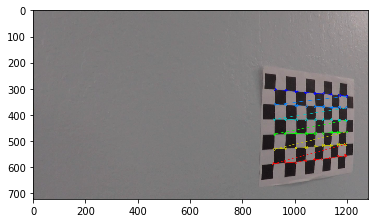

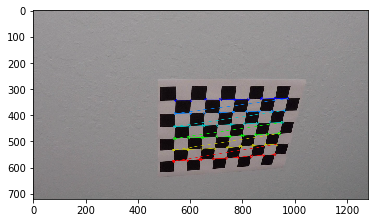

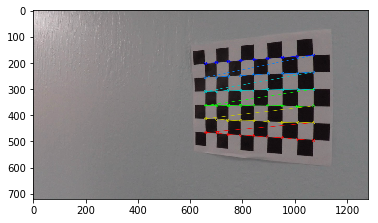

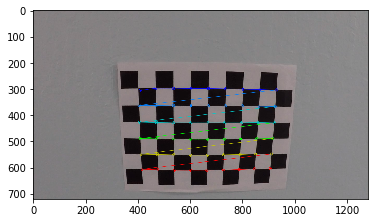

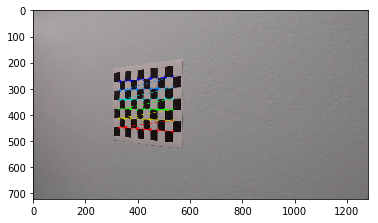

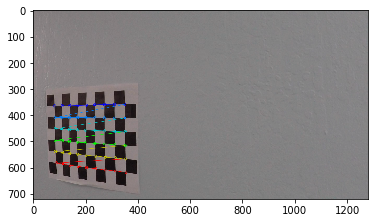

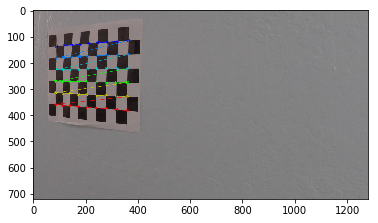

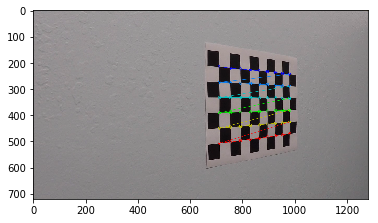

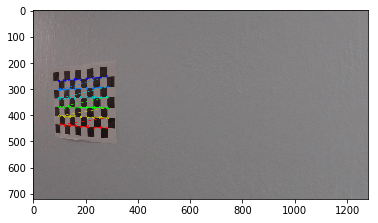

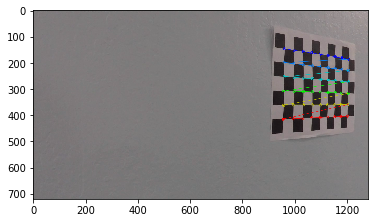

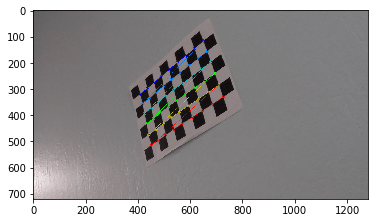

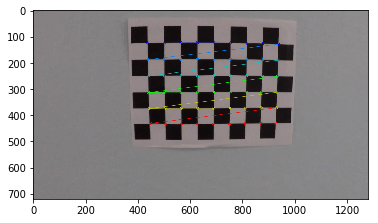

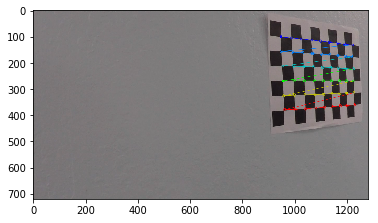

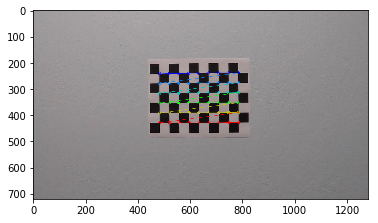

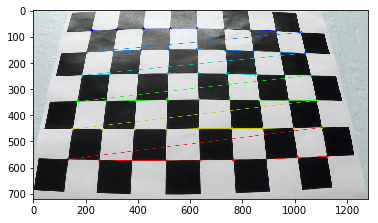

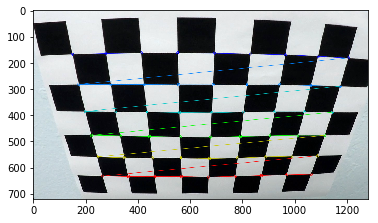

In [2]:
images=glob.glob('camera_cal/calibration*.jpg')

objpoints=[] #3D points in real world
imagepoints=[] #2D points in images

nx=9
ny=6

objp=np.zeros((ny*nx,3),np.float32)
objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1,2)



for fname in images:
    img=cv2.imread(fname)
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners=cv2.findChessboardCorners(gray,(nx,ny),None)
    
    if ret==True:
        imagepoints.append(corners)
        objpoints.append(objp)
        img=cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
        plt.imshow(img)
        plt.show()

ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints, imagepoints, gray.shape[::-1],None,None)


In [3]:
#Save the 'mtx' and 'dist' as a pickle file
dist_pickle={}
dist_pickle["mtx"]=mtx
dist_pickle["dist"]=dist
pickle.dump(dist_pickle, open("wide_dist_pickle.p", "wb"))

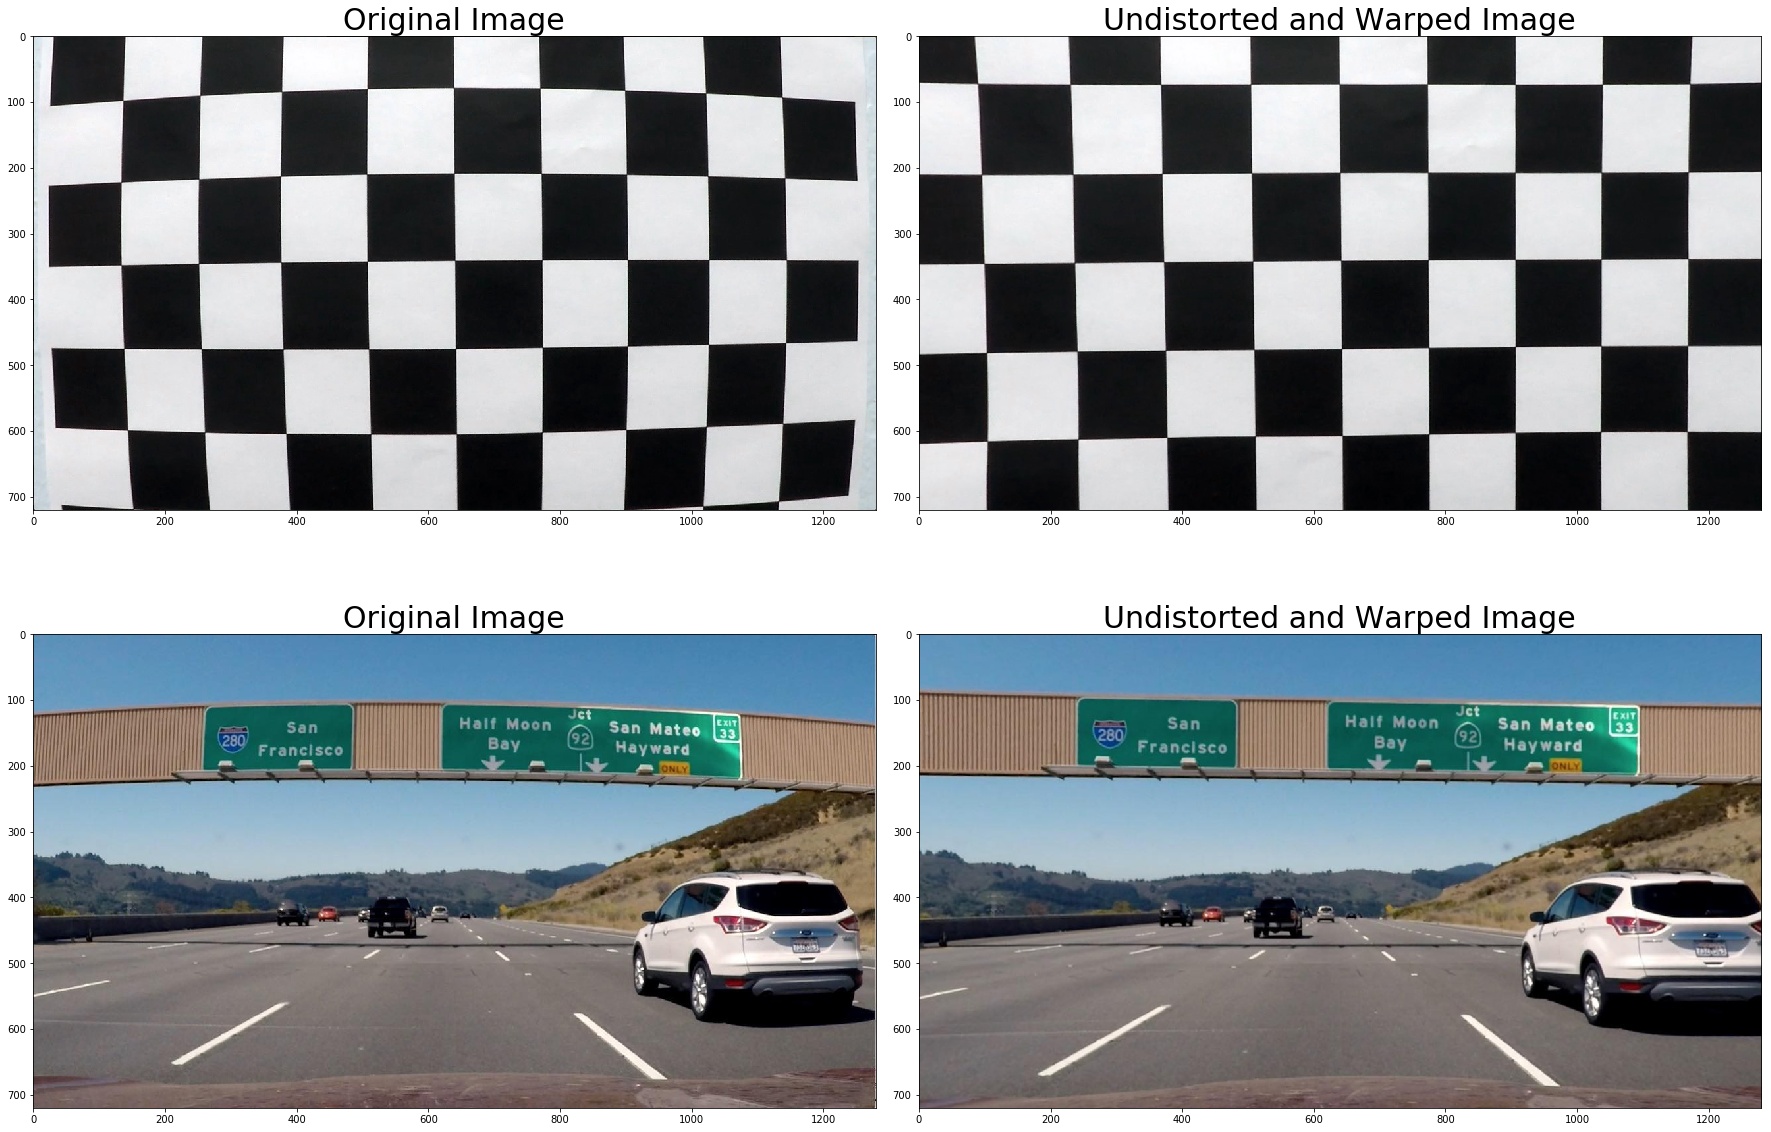

In [4]:
# Read in the saved objpoints and imagepoints
dist_picke=pickle.load(open("wide_dist_pickle.p", "rb"))
mtx=dist_pickle["mtx"]
dist=dist_pickle["dist"]

img1 = cv2.imread('camera_cal/calibration1.jpg')
img2 = mpimg.imread('test_images/signs_vehicles_xygrad.png')

undist1=cv2.undistort(img1,mtx,dist,None,mtx)
undist2=cv2.undistort(img2,mtx,dist,None,mtx)

f, ax = plt.subplots(2, 2, figsize=(24, 18))
f.tight_layout()
ax[0,0].imshow(img1)
ax[0,0].set_title('Original Image', fontsize=30)
ax[0,1].imshow(undist1)
ax[0,1].set_title('Undistorted and Warped Image', fontsize=30)
ax[1,0].imshow(img2)
ax[1,0].set_title('Original Image', fontsize=30)
ax[1,1].imshow(undist2,cmap='gray')
ax[1,1].set_title('Undistorted and Warped Image', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Pipeline

In [5]:
def hls_select_s(img,thresh):
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    s_channel=hls[:,:,2]
    binary_s=np.zeros_like(s_channel)
    binary_s[(s_channel>thresh[0])&(s_channel<=thresh[1])]=1
    return binary_s

def hls_select_l(img,thresh):
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    l_channel=hls[:,:,1]
    binary_l=np.zeros_like(l_channel)
    binary_l[(l_channel>thresh[0])&(l_channel<=thresh[1])]=1
    return binary_l

def rgb_select_r(img,thresh):
    r_channel=img[:,:,0]
    binary_r = np.zeros_like(r_channel)
    binary_r[(r_channel >= (thresh[0]-15)) & (r_channel <= thresh[1])] = 1
    return binary_r

def rgb_select_g(img,thresh):
    g_channel=img[:,:,1]
    binary_g = np.zeros_like(g_channel)
    binary_g[(g_channel >= thresh[0]) & (g_channel <= thresh[1])] = 1
    return binary_g

def rgb_select_b(img,thresh):
    b_channel=img[:,:,2]
    binary_b = np.zeros_like(b_channel)
    binary_b[(b_channel >= thresh[0]) & (b_channel <= thresh[1])] = 1
    return binary_b

def abs_sobel_thresh_x(img,thresh):
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x  gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobelx=np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0))
    scaled_sobelx=np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    binary_sobelx = np.zeros_like(scaled_sobelx)
    binary_sobelx[(scaled_sobelx >= thresh[0]) & (scaled_sobelx <= thresh[1])] = 1
        
    return binary_sobelx

def abs_sobel_thresh_y(img,thresh):
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x  gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobely=np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1))
    scaled_sobely=np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold x gradient
    binary_sobely = np.zeros_like(scaled_sobely)
    binary_sobely[(scaled_sobely >= thresh[0]) & (scaled_sobely <= thresh[1])] = 1
        
    return binary_sobely

def mag_thresh(img,thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    # 3) Calculate the magnitude .
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    binary_mag_thresh = np.zeros_like(gradmag)
    binary_mag_thresh[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    
    return binary_mag_thresh

def lab_select_l(img,thresh):
    lab=cv2.cvtColor(img,cv2.COLOR_RGB2Lab)
    l_channel=img[:,:,0]
    binary_lab_l = np.zeros_like(l_channel)
    binary_lab_l[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_lab_l

def pipeline_new(img, s_thresh,l_thresh,rgb_thresh, sx_thresh, sy_thresh,thresh,lab_l_thresh):
    binary_s_output=hls_select_s(img,s_thresh)
    binary_l_output=hls_select_l(img,l_thresh)
    binary_r_output=rgb_select_r(img,rgb_thresh)
    binary_g_output=rgb_select_g(img,rgb_thresh)
    binary_b_output=rgb_select_b(img,rgb_thresh)
    binary_sobelx_output=abs_sobel_thresh_x(img,sx_thresh)
    binary_sobely_output=abs_sobel_thresh_y(img,sy_thresh)
    binary_lab_l_output=lab_select_l(img,lab_l_thresh)
    binary_mag_thresh_output=mag_thresh(img,thresh)
        
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(binary_sobelx_output)
    combined_binary[(binary_s_output == 1) &(binary_l_output==1)| (binary_sobelx_output == 1) & (binary_sobely_output == 1)&(binary_mag_thresh_output == 1)|(binary_r_output == 1)&(binary_g_output == 1)&(binary_b_output == 1)] = 1
  #  combined_binary[(binary_s_output == 1)|((binary_r_output == 1) & (binary_g_output == 1)& (binary_b_output == 1)) ] = 1 
    #combined_binary[((binary_s_output == 1)&(binary_sobelx_output == 1)) |((binary_s_output == 1)& (binary_sobely_output == 1))|((binary_r_output == 1) & (binary_g_output == 1)& (binary_b_output == 1))  ] = 1 
   # combined_binary[((binary_s_output == 1)&(binary_lab_l_output == 1)) |((binary_g_output == 1)& (binary_b_output == 1)&(binary_r_output == 1))] = 1 
  
    return combined_binary

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


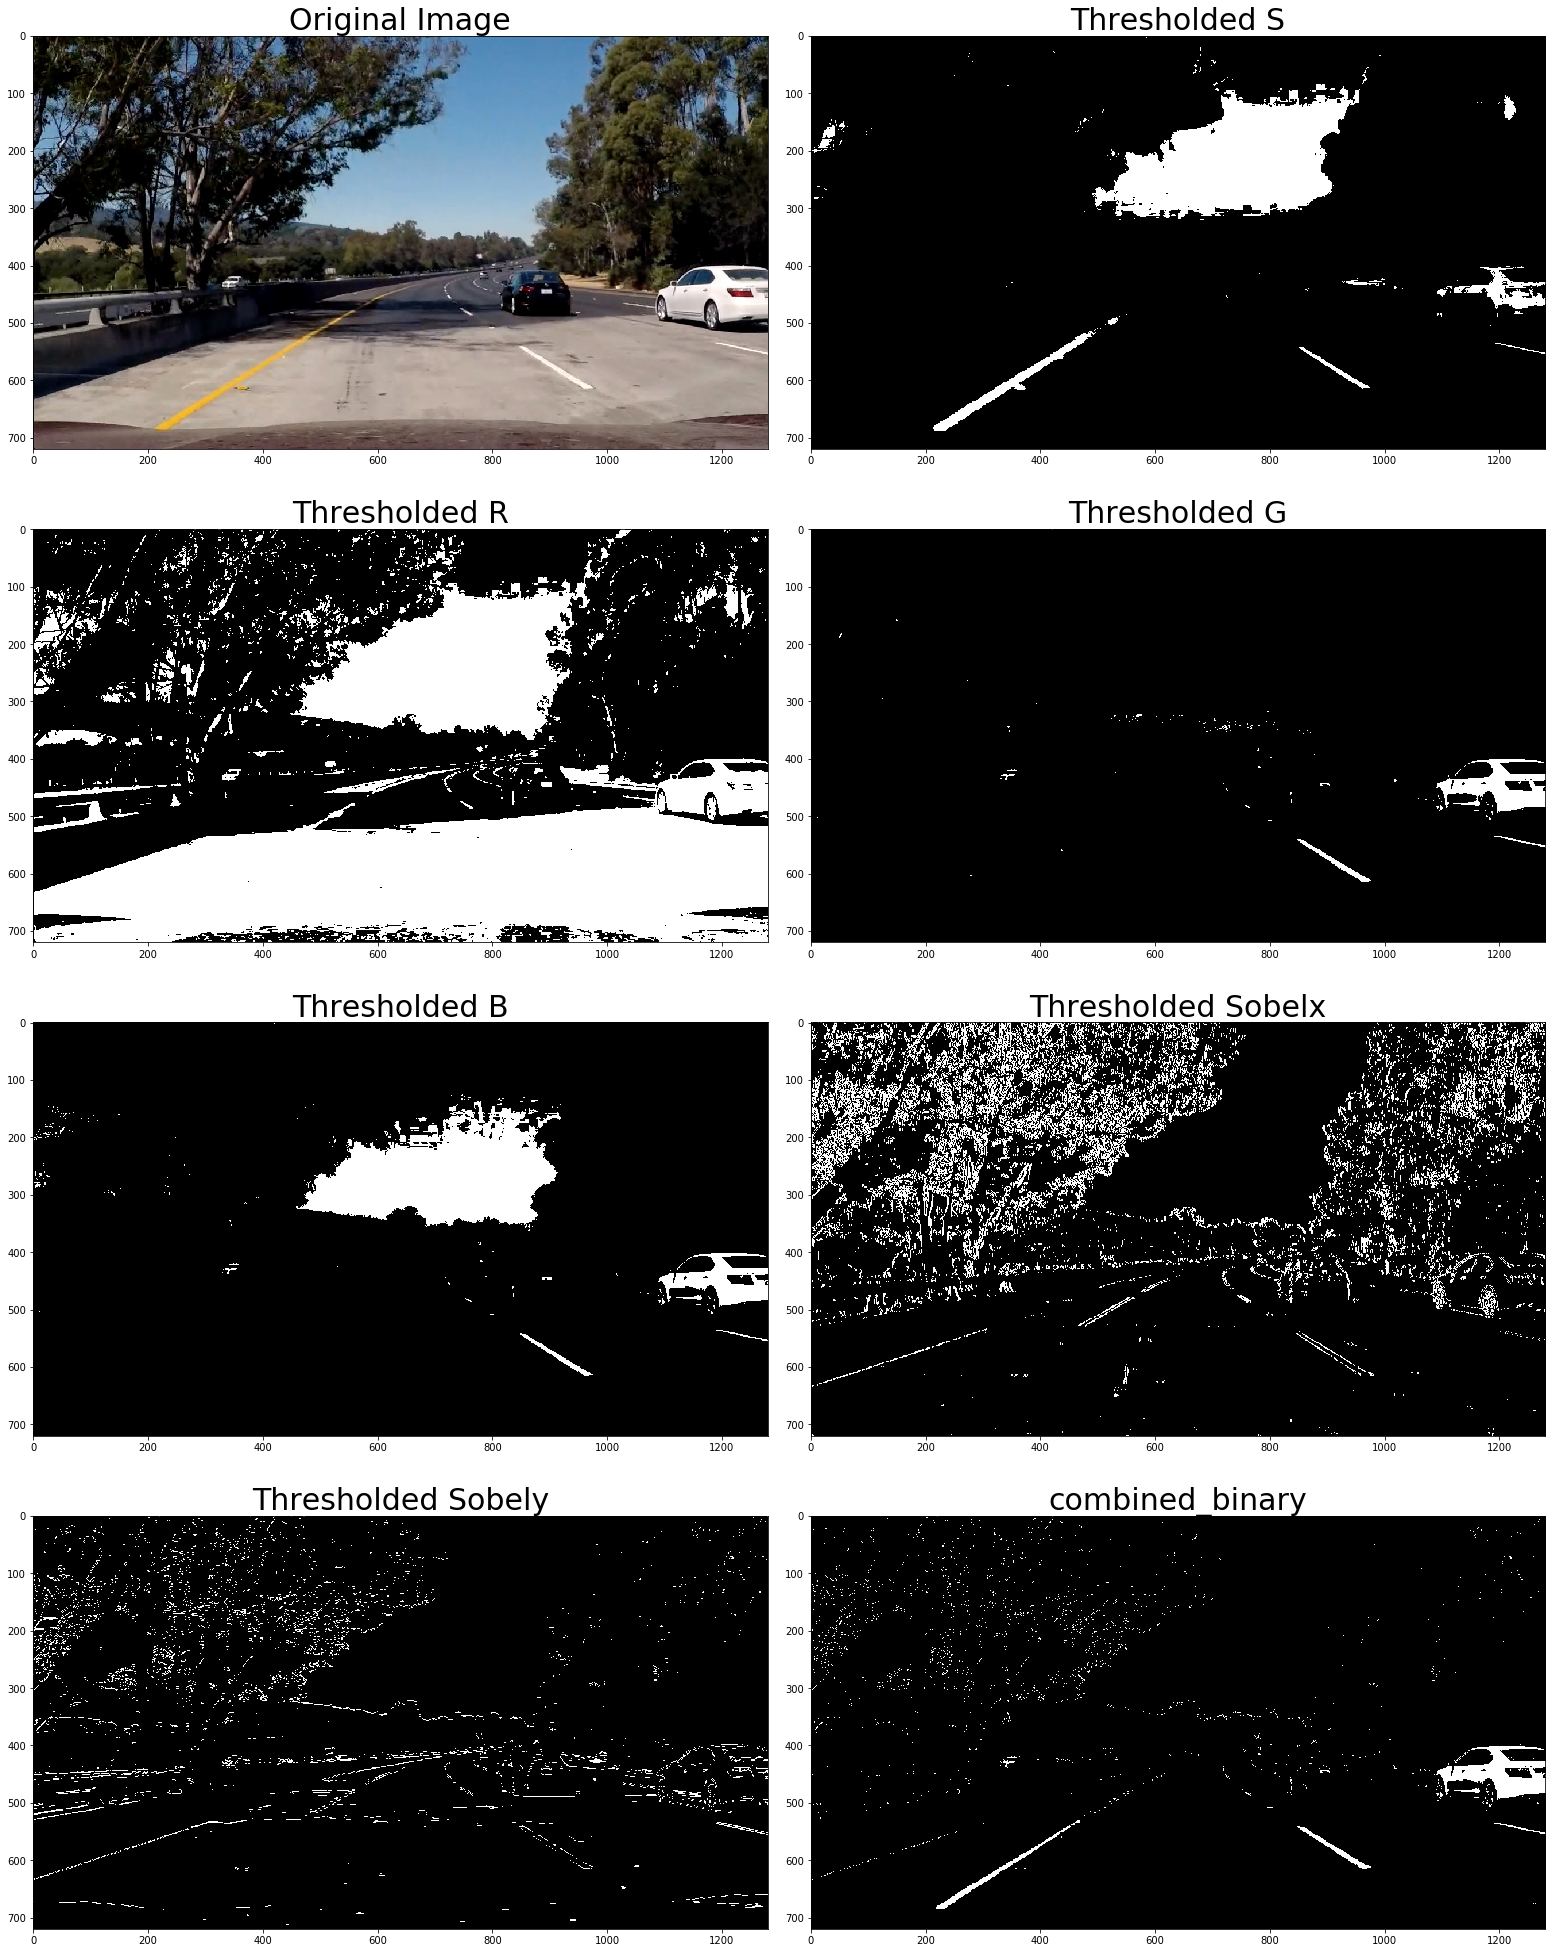

In [6]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# Read in the saved objpoints and imagepoints
dist_picke=pickle.load(open("wide_dist_pickle.p", "rb"))
mtx=dist_pickle["mtx"]
dist=dist_pickle["dist"]

#img = mpimg.imread('False/frame1036.jpg')
img = mpimg.imread('test_images/test5.jpg')

binary_s_output=hls_select_s(img,thresh=(90,255))
binary_r_output=rgb_select_r(img,thresh=(200,255))
binary_g_output=rgb_select_g(img,thresh=(200,255))
binary_b_output=rgb_select_b(img,thresh=(200,255))
binary_lab_l_output=lab_select_l(img,thresh=(100,255))
binary_mag_thresh_output=mag_thresh(img,thresh=(20,255))
binary_sobelx_output=abs_sobel_thresh_x(img,thresh=(20,100))
binary_sobely_output=abs_sobel_thresh_y(img,thresh=(50,100))
combined_output=pipeline_new(img, s_thresh=(180, 255),l_thresh=(100,255),rgb_thresh=(200,255), sx_thresh=(30,255), sy_thresh=(50,100), thresh=(30,100),lab_l_thresh=(225,255))

print(binary_r_output&binary_g_output&binary_g_output)
print(binary_r_output|binary_g_output|binary_b_output)



f, ax = plt.subplots(4, 2, figsize=(21, 30))
f.tight_layout()
ax[0,0].imshow(img)
ax[0,0].set_title('Original Image', fontsize=30)
ax[0,1].imshow(binary_s_output&binary_lab_l_output,cmap='gray')
ax[0,1].set_title('Thresholded S', fontsize=30)
ax[1,0].imshow(binary_lab_l_output,cmap='gray')
ax[1,0].set_title('Thresholded R', fontsize=30)
ax[1,1].imshow(binary_g_output,cmap='gray')
ax[1,1].set_title('Thresholded G', fontsize=30)
ax[2,0].imshow(binary_b_output,cmap='gray')
ax[2,0].set_title('Thresholded B', fontsize=30)
ax[2,1].imshow(binary_sobelx_output,cmap='gray')
ax[2,1].set_title('Thresholded Sobelx', fontsize=30)
ax[3,0].imshow(binary_sobely_output,cmap='gray')
ax[3,0].set_title('Thresholded Sobely', fontsize=30)
ax[3,1].imshow(combined_output,cmap='gray')
ax[3,1].set_title('combined_binary', fontsize=30)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)


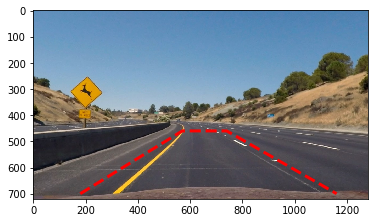

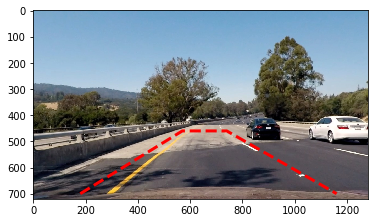

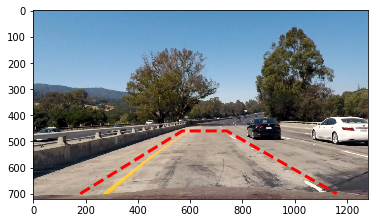

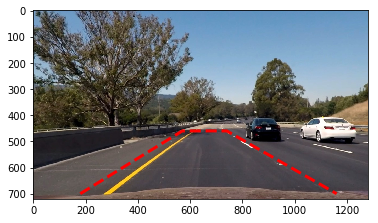

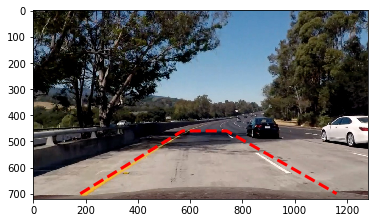

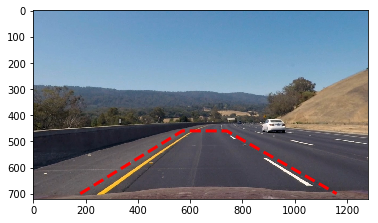

In [7]:
images=glob.glob('test_images/test*.jpg')

for fname in images:
    img=mpimg.imread(fname)
    undist=cv2.undistort(img,mtx,dist,None,mtx)
    src_c=[(180,700),(570,460),(740,460),(1160,700)]
 #   src_c=[(200,700),(595,460),(725,460),(1125,700)]
    

   
    x=[src_c[0][0],src_c[1][0],src_c[2][0],src_c[3][0]]
    y=[src_c[0][1],src_c[1][1],src_c[2][1],src_c[3][1]]
    plt.plot(x,y,'r--',lw=3)
    plt.imshow(undist,cmap='gray')
    plt.show()

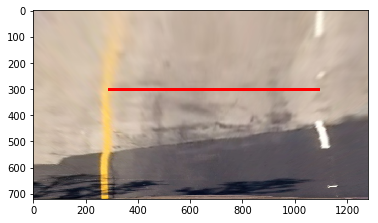

In [8]:
image = mpimg.imread('test_images/test4.jpg')

undist1=cv2.undistort(image,mtx,dist,None,mtx)

def corners_wraped(img):
        src=np.float32(src_c)
        dst=np.float32([(160,720),(160,0),(1160,0),(1160,720)])
      #  dst=np.float32([(250,720),(250,0),(1150,0),(1150,720)])
        M=cv2.getPerspectiveTransform(src,dst)
        Minv=cv2.getPerspectiveTransform(dst, src)
        warped=cv2.warpPerspective(img,M,(image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
        
        return M,Minv,warped
    
M,Minv,warped=corners_wraped(undist1)

x=[290,1090]
y=[300,300]
plt.plot(x,y,'r-',lw=3) 
plt.imshow(warped,cmap='gray')
plt.show()

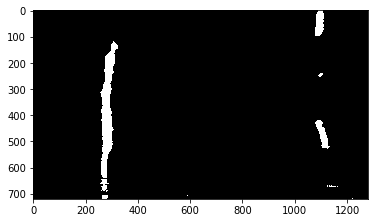

In [9]:
result8=pipeline_new(warped,s_thresh=(170, 255),l_thresh=(100,255),rgb_thresh=(200,255), sx_thresh=(30,255), sy_thresh=(50,100), thresh=(30,100),lab_l_thresh=(225,255))

plt.imshow(result8,cmap='gray')

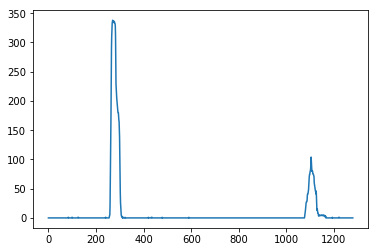

In [10]:
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half,axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(result8)

# Visualize the resulting histogram
plt.plot(histogram)

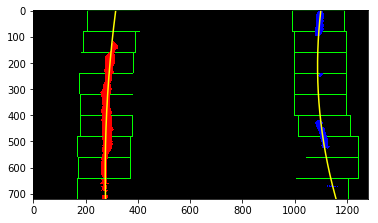

In [11]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
 
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        ### (`right` or `leftx_current`) on their mean position ###
        pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
#    print(left_fit)
#    print(right_fit)


    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fitx,right_fitx,ploty


out_img,left_fitx,right_fitx,ploty = fit_polynomial(result8)

plt.imshow(out_img)

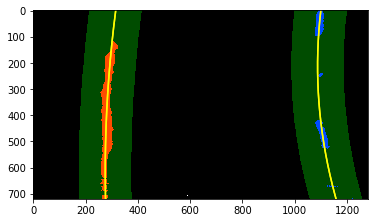

In [22]:
left_fit = np.array([  1.05437653e-04,  -1.29814976e-01,   3.15356831e+02])
right_fit = np.array([ 2.74285477e-04,  -1.16508007e-01,   1.09952973e+03])


def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    out_img,left_fitx,right_fitx,ploty = fit_polynomial(binary_warped)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result,left_fitx,right_fitx,ploty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result1,left_fitx,right_fitx,ploty = search_around_poly(result8)


# View your output
plt.imshow(result1)

In [23]:
def calc_curvature(leftx,rightx):
    ym_per_pix = 25/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension

    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval =719

    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    #curvature=(left_curverad+right_curverad)/2
    #min_curvature=min(left_curverad,right_curverad)

    #left_centre=left_fit[0]*y_eval**2 + left_fit[1]*y_eval +left_fit[2]
    #right_centre=right_fit[0]*y_eval**2 + right_fit[1]*y_eval +right_fit[2]
    #centre =1.5*(left_centre-right_centre)/2
    return left_curverad,right_curverad

    
    # Should see values of 533.75 and 648.16 here, if using
    # the default `generate_data` function with given seed number

left_curverad,right_curverad=calc_curvature(left_fitx,right_fitx)
#print(left_curverad)
#print(right_curverad)

In [24]:
def calc_offset(img, leftx, rightx):
    #Define conversions in x from pixels space to meters
    xm_per_pix = 3.7/800 # meters per pixel in x dimension
    
    midpoint = img.shape[1]//2
    cur_position = (leftx[-1] + rightx[-1])/2
    
    #return offset in meters
    return (midpoint - cur_position) * xm_per_pix

offset = calc_offset(img, left_fitx, right_fitx)
#print(offset, 'm')

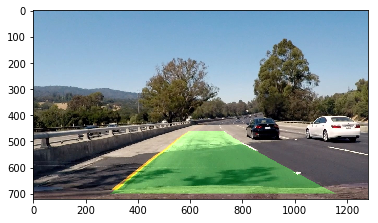

In [25]:
def unwarp(image, warped_binary, left_points, right_points, Minv):
    
    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = left_points
    right_fitx = right_points
    ploty = ploty

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(image, 1, newwarp, 0.3, 0), color_warp 


img_lane,color_warp=unwarp(image,result8,left_fitx,right_fitx,Minv)
plt.imshow(img_lane)

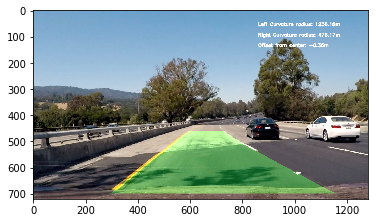

In [26]:

def annotate_video(color_unwarped,small,left_fit, right_fit, offsets, lcurvatures, rcurvatures):
    h, w = color_unwarped.shape[:2]
    
    thumb_ratio = 0.2
    thumb_h, thumb_w = int(thumb_ratio * h), int(thumb_ratio * w)

    off_x, off_y = 20, 15

    
 #   blend_on_road=color_unwarped
     # add thumbnail of bird's eye view 
 #   thumb_binary = cv2.resize(small, dsize=(thumb_w, thumb_h)) 
 #   thumb_binary = np.dstack([thumb_binary, thumb_binary, thumb_binary]) * 255 
    
 #   blend_on_road[off_y:thumb_h+off_y, off_x:off_x+thumb_w, :] = thumb_binary

       
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(color_unwarped, 'Left Curvature radius: {:.02f}m'.format(lcurvatures), (860, 60), font, 0.6, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(color_unwarped, 'Right Curvature radius: {:.02f}m'.format(rcurvatures), (860, 100), font, 0.6, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(color_unwarped, 'Offset from center: {:.02f}m'.format(offsets), (860, 140), font, 0.6, (255, 255, 255), 2, cv2.LINE_AA)

    return color_unwarped

final_output = annotate_video(img_lane,result8,left_fitx,right_fitx,offset, left_curverad,right_curverad)
plt.imshow(final_output)

In [27]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import pickle

%matplotlib inline

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [29]:
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def video_pipline(frame1):
    
    #find lanes
    undistorted1 = cv2.undistort(frame1, mtx, dist, None, mtx)
    
    thresh_binary1 = pipeline_new(undistorted1,s_thresh=(180, 255),l_thresh=(100,255),rgb_thresh=(200,255), sx_thresh=(30,255), sy_thresh=(50,100), thresh=(30,100),lab_l_thresh=(225,255))
    
    M , Minv,warped_binary1 = corners_wraped(thresh_binary1)
    
    M , Minv,warped_binary2 = corners_wraped(undistorted1)
    
    thresh_binary2 = pipeline_new(warped_binary2,s_thresh=(180, 255),l_thresh=(100,255),rgb_thresh=(200,255), sx_thresh=(30,255), sy_thresh=(50,100), thresh=(30,100),lab_l_thresh=(225,255))
    
    #detected_lane, fit_lane, fitx_lane, ploty  = find_lanes(warped_binary)
    detected_lane1, left_fitx,right_fitx,ploty = search_around_poly(warped_binary1)
    
    color_unwarped1, color_warp = unwarp(frame1, warped_binary1, left_fitx, right_fitx,  Minv)
    
    #get Off_set and Curvature
    offset = calc_offset(frame1, left_fitx, right_fitx)
    left_curverad,right_curverad=calc_curvature(left_fitx,right_fitx)
        
    #add information to the video
    final_output = annotate_video(color_unwarped1,thresh_binary2,left_fitx,right_fitx,offset, left_curverad,right_curverad)
    return final_output

[MoviePy] >>>> Building video project_output_video.mp4
[MoviePy] Writing video project_output_video.mp4


100%|█████████▉| 1260/1261 [08:43<00:00,  2.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_video.mp4 

CPU times: user 5min 45s, sys: 50.2 s, total: 6min 35s
Wall time: 8min 46s


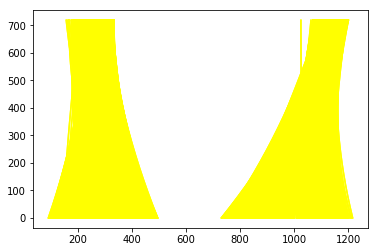

In [30]:
output = 'project_output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(video_pipline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

In [31]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output))

In [89]:
#Save video as images
#Opens the Video file
cap= cv2.VideoCapture('project_output_video.mp4.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite('./False/frame'+str(i)+'.jpg',frame)
    i+=1
 
cap.release()
cv2.destroyAllWindows()

error: /tmp/build/80754af9/opencv_1512491964794/work/modules/highgui/src/window.cpp:605: error: (-2) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function cvDestroyAllWindows
